In [3]:
import os
import re
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
policydict = {1 : 'financial',
             2 : 'bank',
             3 : 'insurance',
             4 : 'SME',
             5 : 'financialcustomer',
             6 : 'capitalmarket',
             7 : 'global'}

#
# crawling from the website
#
rangeofpage = 100
docudict = {}
for policy in list(policydict.keys()):
    print(f"start content extracting the content from policy {policydict[policy]}")
    for pagecnt in range(1,rangeofpage):
        # greater than 2 page is "https://www.fsc.go.kr/po010104?curPage=2&srchCtgry=4" Unlike first page , they add the 'curpage=2' parameter
        response = requests.get(f'https://www.fsc.go.kr/po010104?curPage={pagecnt}&srchCtgry={policy}')
        # html parser
        soup = BeautifulSoup(response.text, 'html.parser')
        # contents in single page       
        totalcontents = int(soup.select_one('#container > div.content-body > div > div.board-list-wrap > ul > li:nth-child(1) > div > div.count').text) - int(soup.select_one('#container > div.content-body > div > div.board-list-wrap > ul > li:nth-child(10) > div > div.count').text)

        for num in range(1,totalcontents):
            title = soup.select_one(f'#container > div.content-body > div > div.board-list-wrap > ul > li:nth-child({num}) > div > div.cont > div.subject > a')['title']
            href = soup.select_one(f'#container > div.content-body > div > div.board-list-wrap > ul > li:nth-child({num}) > div > div.cont > div.subject > a')['href']
            content_idx = soup.select_one(f'#container > div.content-body > div > div.board-list-wrap > ul > li:nth-child({num}) > div > div.count').text
            content_publishday = soup.select_one(f'#container > div.content-body > div > div.board-list-wrap > ul > li:nth-child({num}) > div > div.day').text
            docudict[title] = {}
            docudict[title]['href'] = href
            docudict[title]['policy'] = policydict[policy]
            docudict[title]['publish_day'] = content_publishday
            docudict[title]['idxofcontent'] = content_idx

start content extracting the content from policy financial
start content extracting the content from policy bank
start content extracting the content from policy insurance
start content extracting the content from policy SME
start content extracting the content from policy financialcustomer
start content extracting the content from policy capitalmarket
start content extracting the content from policy global


In [7]:
%%time
BASEURL = 'https://www.fsc.go.kr'
docuurlbox = [docudict[title]['href'] for title in list(docudict.keys())]
contenturl = [BASEURL + docuurl for docuurl in docuurlbox]
textbox = []

for url in contenturl:
    response = requests.get(url)
    # html parser
    soup = BeautifulSoup(response.text, 'html.parser')
    
    testtext = soup.select_one('#container > div.content-body > div > div.body > div.cont').text
    pretext = re.sub(r'[\n\xa0]+', ' ', testtext)
    textbox.append(pretext)

CPU times: user 2min 30s, sys: 999 ms, total: 2min 31s
Wall time: 14min 46s


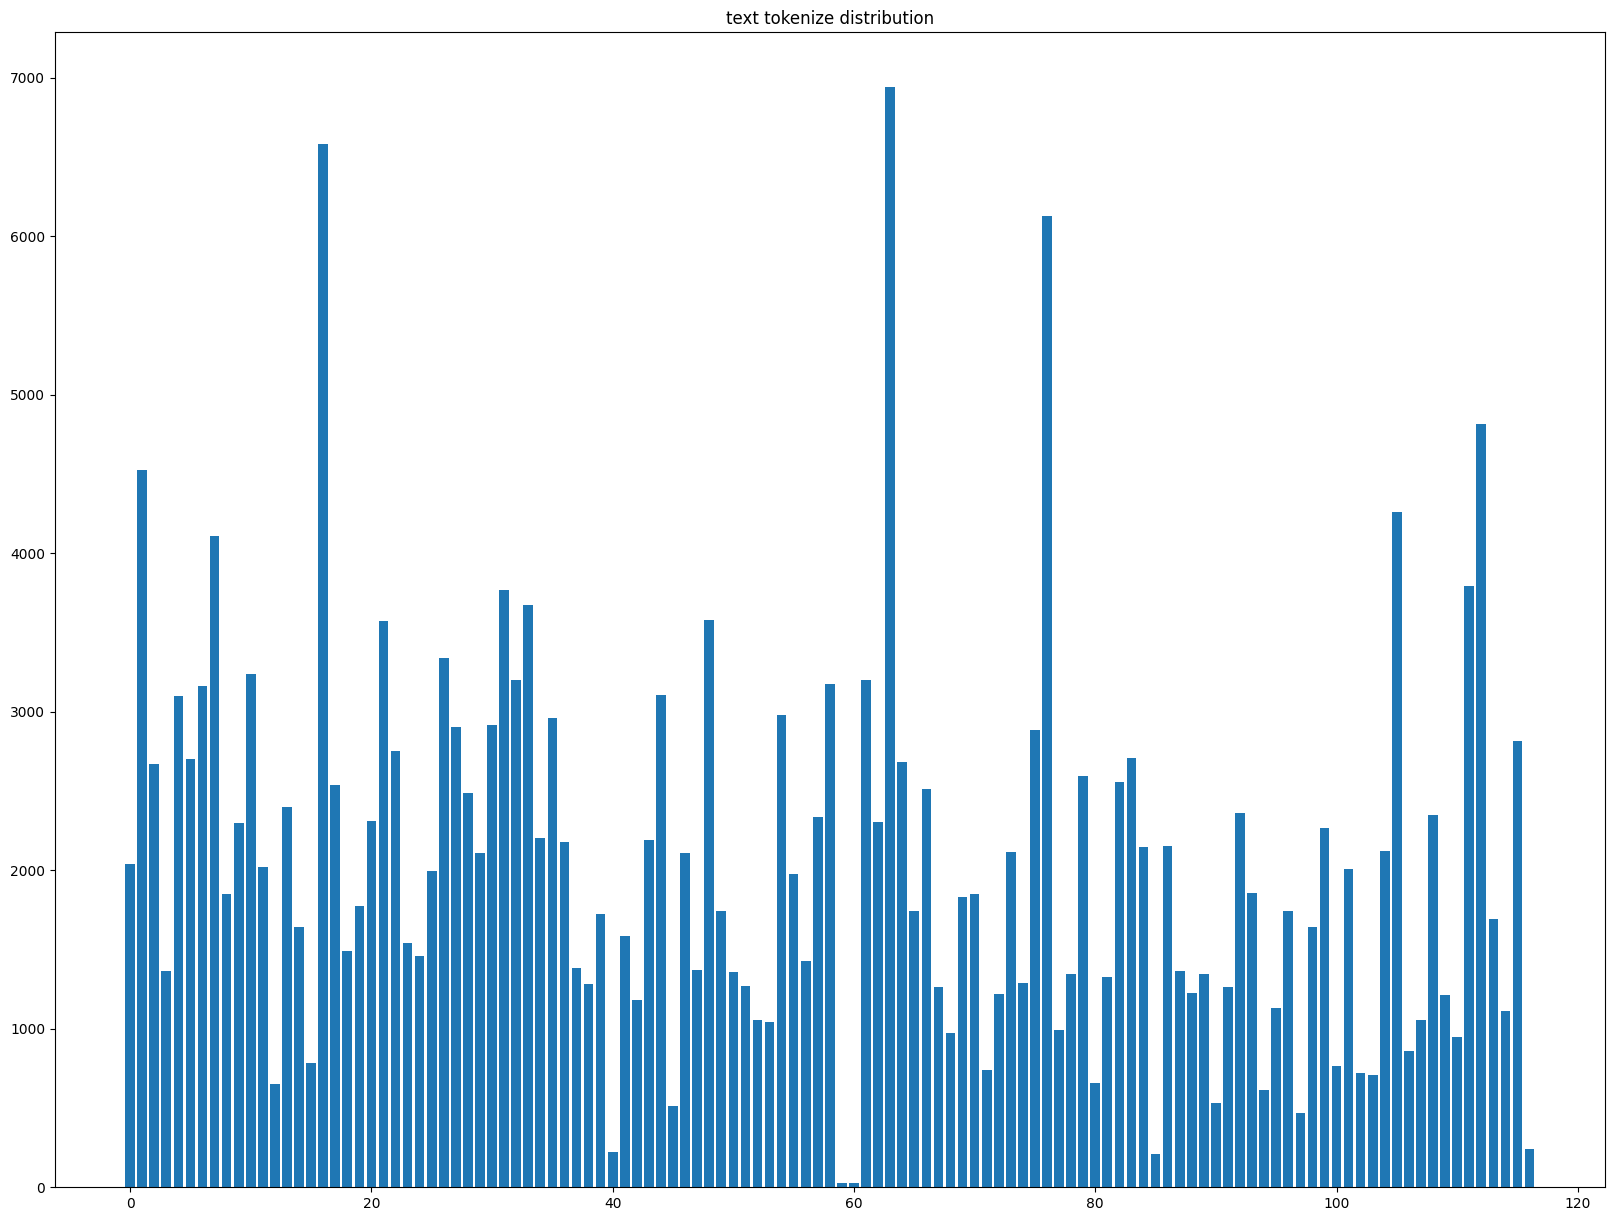

In [6]:
# for determining chunk size and overlap parameter, we check the doc distribution
lengthbox = [len(textbox[num]) for num in range(len(textbox))]
plt.figure(figsize=(20,15))
plt.title('text tokenize distribution')
plt.bar(range(len(lengthbox)),lengthbox)
plt.show()

In [ ]:
# save the dataset
for i in range(len(textbox)):
    text_to_write = textbox[i]
    with open(f'./textdata/{i}thtext.txt', 'w') as file:
        file.write(text_to_write)

In [ ]:
# check the result
os.listdir('./textdata')[:10]

# text preprocessing

In [8]:
# 라이브러리 불러오기
import re, os, json
import pandas as pd
import warnings
from typing import List

from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
from langchain.chains import GraphCypherQAChain
from langchain.vectorstores.neo4j_vector import Neo4jVector
from langchain.graphs import Neo4jGraph
from langchain.prompts.prompt import PromptTemplate
from langchain_openai import OpenAIEmbeddings

from py2neo import Graph
from graphdatascience import GraphDataScience

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") 

# 클라이언트에서 Neo4j 원격 호출환경 구성
uri = "bolt://172.17.0.2:7687"
username = "neo4j"
password = "graphrag2727"
graph = Graph(uri, auth=(username, password))
gds = GraphDataScience(
    uri,
    auth=(username, password),
    aura_ds=False
)

def init_graph_data():
    graph.run("MATCH (n) DETACH DELETE n")

# 그래프 데이터 초기화
# init_graph_data()

In [11]:
# 하나의 문서를 여러 개의 chunk로 분리 -> (langchain) Document로 리턴
def chunk_document(docs, chunk_size, chunk_overlap):
    text_splitter = RecursiveCharacterTextSplitter(
              chunk_size = chunk_size,
              chunk_overlap  = chunk_overlap,
              length_function = len,
          )
          
    documents = text_splitter.create_documents([docs])
    return documents

# 하나의 문서를 여러 개의 chunk로 분리 -> Text로 리턴
def chunk_text(docs, chunk_size, chunk_overlap):
    text_splitter = RecursiveCharacterTextSplitter(
              chunk_size = chunk_size,
              chunk_overlap  = chunk_overlap,
              length_function = len,
          )
    documents = text_splitter.split_text(docs)
    return documents

# 벡터 임베딩을 그래프에 로드
def vector_load(text):
    neo4j_vector = Neo4jVector.from_documents(
        text,
        embedding = OpenAIEmbeddings(),
        url=uri,
        username=username,
        password=password
    )
    return neo4j_vector

# 벡터 검색 결과 확인
def search_context(neo4j_vector, question):
    vector_results = neo4j_vector.similarity_search(question, k=1)
    vector_result = vector_results[0].page_content
    return vector_result

def chunks(xs, n=3):
    n = max(1, n)
    return [xs[i:i + n] for i in range(0, len(xs), n)]

def get_embedding(text: str, model="text-embedding-3-small", **kwargs) -> List[float]:
    client = OpenAI(max_retries=5)
    # replace newlines, which can negatively affect performance.
    response = client.embeddings.create(input=[text], model=model, **kwargs)
    return response.data[0].embedding

# chunk 단위의 임베딩을 생성하며, chunk 식별 정보(sequence) 생성
def create_text_embedding_entries(doc, title:str , policy:str, chunk_size:int, chunk_overlap:int):
    docs = chunk_text(doc, chunk_size, chunk_overlap)
    document_title = title
    document_tag = policy
    res = []    
    seq_id = -1
    
    for d in chunks(docs):
        # embedding candidate -> Financial Kakaobank embedding 
        for i in range(len(d)):
            seq_id += 1
            res.append({'name': document_title,
                        'tag' : document_tag,
                        'seqId': seq_id,
                        'contextId': document_title + str(seq_id),  # unique 
                        'textEmbedding': get_embedding([i]),  # chunked
                        'text': d[i]})
    return res

# 제공된 벡터 임베딩을 그래프에 업데이트
def update_embeddings(emb):
    total = len(emb)
    count = 0
    for d in chunks(emb, 100):
        gds.run_cypher('''
        UNWIND $records AS record
        MERGE(d:Docu {name:record.name, tag:record.tag})
        CREATE(c:Chunk {chunkid:record.contextId, seqid:record.seqId, text:record.text})
        MERGE(d)-[:CHUNKED]->(c)
        with c, record
        CALL db.create.setVectorProperty(c, 'embedding', record.textEmbedding)
        YIELD node
        RETURN distinct 'done'
        ''', params = {'records':d})
        count += len(d)

In [190]:
# example load
docs = chunk_document(docs=textbox[2], chunk_size=chunk_size,chunk_overlap=chunk_overlap)
# 분리된 문서를 그래프에 로드
long_vector = vector_load(docs)

In [176]:
question = "금융위원장이 기념사에서 뭐라했어?"
print(search_context(long_vector, question))

1월 24일, 김주현 금융위원회 위원장은 이복현 금융감독원장과 함께 증권업계 및 유관기관을 대상으로 간담회를 개최하였다. 이번 간담회는 국민 자산형성 지원을 위한 증권업계의 역할과 증권업계의 신뢰제고 방안 등을 논의하기 위해 마련되었다. < 간담회 개요 > ㅇ 일시/장소 : ’24.1.24. (수) 10:00~11:20 / 금융투자협회 23층 대회의실 ㅇ 참석자 : 금융위원회 위원장, 금융감독원 원장, 한국거래소 이사장, 금융투자협회장, 한국상장사협의회 부회장, 코스닥협회 부회장, 10개 증권사 대표* * [종투사, 5사] KB증권, NH투자증권, 미래에셋증권, 삼성증권, 한국투자증권, [중소형, 3사] DB투자증권, 대신증권, 신영증권, [외국계, 2사] 모간스탠리, 제이피모간 김주현 금융위원장은 모두발언을 통해 “혁신기업 지원을 통해 경제 성장의 돌파구를 마련하고, 국민 자산형성의 사다리로서 자본시장의 역할이 중요하다”고 강조하며, 이러한 맥락에서 “자본시장 발전을 위해 그간 3가지 방향의 제도개선*을 일관성 있게 꾸준히 추진해 왔다”고 언급하였다. * ➊ 일반주주 이익 보호, ➋ 국제적 정합성 제고, ➌ 불공정거래 대응 강화 김 위원장은 지금까지의 정책 방향을 일관성 있게 견지함과 동시에, “자본시장을 통한 국민 자산형성 지원에 보다 직접적으로 초점을 둔 정책을 추진해 나가겠다”고 밝혔다. 이를 위해 ➊정부는 관계부처 간 긴밀한 협의 하에 “증시 수요기반 유지·확충을 위한 세제개편*과 함께, 소액주주 권익 개선을 위한 상법 개정, 지배주주의 편법적인 지배력 확대 방지를 위한 자사주 제도개선 등을 차질없이 추진해 나가겠다”고 발언했다. * 금융투자소득세 폐지, ISA 세제지원 강화 등 한편, 김 위원장은 우리 증시의 저평가 해소를 위해서는 ➋기업 스스로의 역할이 중요함을 강조하면서, “기업의 주주가치 제고 노력을 독려·지원하기 위한 ｢기업 밸류업 프로그램｣을 도입·운용하겠다”고 밝혔다. 김 위원장은 “이 프로그램은 기업 스스로가 자사가 저평가된 이유를 분석

# chunking

In [306]:
# 그래프 데이터 초기화
# init_graph_data()

In [312]:
# all load
from tqdm import tqdm
for i in tqdm(range(len(textbox))):
    vector = create_text_embedding_entries(doc=textbox[i],\
                                           title=list(docudict.keys())[i], \
                                           policy=docudict[list(docudict.keys())[i]]['policy'] ,\
                                           chunk_size=chunk_size, \
                                           chunk_overlap=chunk_overlap)
    update_embeddings(vector)

# question

In [287]:
# 벡터 인덱스를 활용해 높은 유사도의 chunk를 추출
vector_search = """
WITH $embedding AS e
CALL db.index.vector.queryNodes('vector', $k, e) yield node, score
RETURN node.text AS result
"""

graph_instance = Neo4jGraph(url=uri, username=username, password=password)

# text 

In [194]:
import re
from transformers import AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("kakaobank/kf-deberta-base")


def cleaning(text):
    text = re.sub('[^가-힣]', '', text)
    return [text for text in text.split() if len(text) > 1]

def preprocessing(docs):
    testtext = tokenizer.tokenize(docs, max_length=512, truncation=True)
    testlist = list(map(cleaning, testtext))
    words = list(filter(None, testlist))
    return words

In [195]:
# we use splitter for chunking
docs = text_splitter.split_text(textbox[1])
# text preprocessing for each chunk and load
wordslist = [preprocessing(docs[i]) for i in range(len(docs))]

# flatten the list for tfidf
testcorpus = sum(wordslist[0], [])

# tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfv = TfidfVectorizer().fit(testcorpus)
print(tfidfv.vocabulary_)

{'현장': 83, '간담회': 2, '개요': 4, '김주현': 19, '금융': 15, '위원': 52, '주금공': 66, '서울': 40, '중부': 70, '지사': 72, '서울시': 41, '중구': 69, '한강대로': 82, '방문': 32, '하여': 81, '주택': 68, '연금': 51, '접수': 63, '직접': 73, '둘러보': 28, '고령': 7, '노후': 24, '생활': 39, '보장': 35, '강화': 3, '위한': 53, '정책': 64, '방향': 33, '대해': 27, '공사': 8, '보건': 34, '사회': 38, '연구원': 50, '이용자': 55, '관련': 10, '기관': 17, '관계자': 9, '들과': 29, '의견': 54, '나누': 20, '자리': 59, '가졌': 1, '활성': 84, '일시': 58, '장소': 60, '참석자': 76, '금융정책': 16, '국장': 13, '참석': 75, '최형': 79, '이화여대': 56, '경영학': 6, '교수': 11, '김성': 18, '연구': 49, '신한은행': 45, '개인': 5, '솔루션': 43, '본부': 36, '가입자': 0, '논의': 25, '내용': 22, '그간': 14, '성과': 42, '점검': 62, '중장': 71, '제도': 65, '말씀': 30, '모두': 31, '에서': 47, '내년': 21, '부터': 37, '인구': 57, '천만': 77, '넘어서': 23, '초고': 78, '진입': 74, '전망': 61, '언급': 46, '하며': 80, '여전': 48, '주요': 67, '국가': 12, '대비': 26, '수준': 44}


# vector search and context extract

＃ ＲＡＧ

In [186]:
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

vectorstore = FAISS.from_texts(
    ｔｅｓｔｂｏｘ, embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
model = ChatOpenAI()

retrieval_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)
ＱＵＥＳＴＩＯＮ ＝ “”
retrieval_chain.invoke(ＱＵＥＳＴＩＯＮ)

# ＧｒａｐｈＲＡＧ

## ｖｅｃｔｏｒ ｓｅａｒｃｈ

In [ ]:
# 벡터 인덱스를 활용해 높은 유사도의 chunk를 추출
vector_search = """
WITH $embedding AS e
CALL db.index.vector.queryNodes('vector', $k, e) yield node, score
RETURN node.text AS result
"""

graph_instance = Neo4jGraph(url=uri, username=username, password=password)

# 질문을 임베딩으로 변환
question = "What are the different storage classes offered by Amazon S3? Please provide a list of all available storage classes."
embedding = bedrock_embeddings.embed_query(question)

# 컨텍스트 확보
context = graph_instance.query(
    vector_search, {'embedding': embedding, 'k': 3})
   
context = [el['result'] for el in context]
print(context[0])

In [ ]:
retriever = vectorstore.as_retriever()
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
model = ChatOpenAI()

retrieval_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)
ＱＵＥＳＴＩＯＮ ＝ “”
retrieval_chain.invoke(ＱＵＥＳＴＩＯＮ)

In [ ]:
# 1. 기본 : 발견된 chunk의 텍스트만 추출
vector_search = """
WITH $embedding AS e
CALL db.index.vector.queryNodes('vector', $k, e) yield node, score
RETURN node.text AS result
"""

# 2. 문서 전체 : 발견된 chunk와 연계된 전체 문서를 리턴
vector_search_full_documents = """
WITH $embedding AS e
CALL db.index.vector.queryNodes('vector', $k, e) yield node, score
MATCH (s:Service)-[:CHUNKED]->(node)
WITH s
MATCH (s)-[:CHUNKED]->(docs:Chunk)
WITH s, docs
ORDER BY docs.seqid ASC
RETURN s AS service, COLLECT(docs.text) AS result
"""

# 3. 인접 chunk : 발견된 chunk와 인접한 chunk의 텍스트를 리턴
vector_search_larger_chunk = """
WITH $embedding AS e
CALL db.index.vector.queryNodes('vector', $k, e) yield node, score
MATCH (s:Service)-[:CHUNKED]->(node)
WITH s, node.seqid AS seqid
MATCH (s)-[:CHUNKED]->(docs:Chunk)
WHERE docs.seqid >= seqid - 1 AND docs.seqid <= seqid + 1
WITH s, docs
ORDER BY docs.seqid ASC
RETURN s AS service, COLLECT(docs.text) AS result
"""

## ｔｒａｖｅｒｓａｌ ｓｅａｒｃｈ

In [ ]:
CYPHER_GENERATION_TEMPLATE = """

You are an excellent Assistant for generating Cypher Query Language for graph searches. 
You will be exploring a graph that represents the connections between AWS services.

<instruction>
Guidance for answers below
Each Service has relationships with other Services.
 - (s1:Service)-[:]->(s2:Service)
Each Service node is connected to Chunks containing detailed information about the service:
 - (s1:Service)-[:CHUNKED]->(c:Chunk)
Each Chunk has detailed information about the service in its text.
 - (c:Chunk {{c.text}})
 - RETURN c.text
</instruction>

<example>
Here are a few examples of generated Cypher statements for particular questions:
# Question :
Explain instance types Amazon EC2 has.
# Generated Cypher :
MATCH (ec2:Service {{name:"Amazon EC2"}})-[:hasInstanceType]->(s:Service)
WITH s
MATCH (s:Service)-[:CHUNKED]->(c:Chunk)
RETURN COLLECT(DISTINCT c.text) AS Text

# Question :
Explain the cost of each instance type of Amazon EC2.
# Generated Cypher :
MATCH (ec2:Service {{name:"Amazon EC2"}})-[:hasInstanceType]->(s:Service)
WITH s
MATCH (s:Service)-[:CHUNKED]->(c:Chunk)
WHERE c.text CONTAINS "cost"
RETURN COLLECT(DISTINCT c.text) AS Text
</example>

Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.
<schema>
{schema}
</schema>

The question is: 
{question} 
"""

CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=['schema', 'question'], validate_template=True, template=CYPHER_GENERATION_TEMPLATE
)

In [ ]:
graph_instance = Neo4jGraph(url=uri, username=username, password=password)
＃chat_llm = BedrockChat(model_id="anthropic.claude-v2:1", model_kwargs={"temperature": 0.1}, region_name=REGION)

chain = GraphCypherQAChain.from_llm(
    chat_llm,
    graph=graph_instance, 
    cypher_prompt=CYPHER_GENERATION_PROMPT,
    verbose=True,
    validate_cypher=True,
    return_direct=True
)

In [ ]:
def chat(question):
    r = chain(question)
    
    summary_prompt_tpl = f"""Human: 
    Fact: {json.dumps(r['result'])}

    * Describe the above fact as if you are answering this question "{r['query']}"
    * Provide the response according to the keywords provided within the quotation marks.
    * When the fact is not empty, assume the question is valid and the answer is true
    * Do not return helpful or extra text or apologies
    * List the results in rich text format if there are more than one results
    Assistant:
    """
    return llm(summary_prompt_tpl)

def chat_response(input_text):
    try:
        return chat(input_text)
    except:
        return "I'm sorry, there was an error retrieving the information you requested."
        
graph_answer = chat(question) 
print(graph_answer)

Ｒｅｆｅｒｅｎｃｅ ｃｏｄｅ

In [ ]:
def configure_qa_rag_chain(llm, embeddings, embeddings_store_url, username, password):
    general_system_template = """ 
    Use the following pieces of context to answer the question at the end.
    The context contains question-answer pairs and their links from Stackoverflow.
    You should prefer information from accepted or more upvoted answers.
    Make sure to rely on information from the answers and not on questions to provide accurate responses.
    When you find particular answer in the context useful, make sure to cite it in the answer using the link.
    If you don't know the answer, just say that you don't know, don't try to make up an answer.
    ----
    {summaries}
    ----
    Each answer you generate should contain a section at the end of links to 
    Stackoverflow questions and answers you found useful, which are described under Source value.
    You can only use links to StackOverflow questions that are present in the context and always
    add links to the end of the answer in the style of citations.
    Generate concise answers with references sources section of links to 
    relevant StackOverflow questions only at the end of the answer.
    """
    general_user_template = "Question:```{question}```"
    messages = [
        SystemMessagePromptTemplate.from_template(general_system_template),
        HumanMessagePromptTemplate.from_template(general_user_template),
    ]
    qa_prompt = ChatPromptTemplate.from_messages(messages)
    qa_chain = load_qa_with_sources_chain(
        llm,
        chain_type="stuff",
        prompt=qa_prompt,
    )

    # Vector + Knowledge Graph response
    kg = Neo4jVector.from_existing_index(
        embedding=embeddings,
        url=embeddings_store_url,
        username=username,
        password=password,
        database="neo4j",  # neo4j by default
        index_name="stackoverflow",  # vector by default
        text_node_property="body",  # text by default
        retrieval_query="""
    WITH node AS question, score AS similarity
    CALL  { with question
        MATCH (question)<-[:ANSWERS]-(answer)
        WITH answer
        ORDER BY answer.is_accepted DESC, answer.score DESC
        WITH collect(answer)[..2] as answers
        RETURN reduce(str='', answer IN answers | str + 
                '\n### Answer (Accepted: '+ answer.is_accepted +
                ' Score: ' + answer.score+ '): '+  answer.body + '\n') as answerTexts
    } 
    RETURN '##Question: ' + question.title + '\n' + question.body + '\n' 
        + answerTexts AS text, similarity as score, {source: question.link} AS metadata
    ORDER BY similarity ASC // so that best answers are the last
    """,
    )

    kg_qa = RetrievalQAWithSourcesChain(
        combine_documents_chain=qa_chain,
        retriever=kg.as_retriever(search_kwargs={"k": 2}),
        reduce_k_below_max_tokens=False,
        max_tokens_limit=3375,
    )
    return kg_qa